In [2]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det

def check_invertibility(X):
    # X is a (m,d) matrix. m is samples, d is features
    # outputs true false values for (left_inverse_exist,right_inverse_exists)
    use_LI = True if (det(X.T @X) != 0) else False
    use_RI = True if (det(X @ X.T)!= 0) else False
    return (use_LI,use_RI)

def apply_left_inverse(X, y ,L):
    # X as a (m,d) matrix must be overdetermined: m > d
    # y is a d-tuple
    # assumes that X^T @ X is invertible
    (m,d) = X.shape
    w = inv(X.T @ X + L * np.eye(d)) @ X.T @ y
    return w
    
def apply_right_inverse(X,y,L):
    # X is a 2d (m,d)-ndarray
    # X as a (m,d) matrix must be under-determined: m < d
    # y is a 1d (d)-ndarray
    # assumes that X @ X^T  is invertible
    (m,d) = X.shape
    w = X.T @ inv(X @ X.T + L * np.eye(m)) @ y
    return w

## how many monomials?
imagine we have indeterminates $x_1, \cdots, x_n$. We want to create all the possible monomials up to order $D$. This is equivalent to having indeterminates $x_0,x_1, \cdots, x_n$, and asking how many monomials there are of exactly order $D$, then evaluating $x_0 = 1$.

Hence, we want to choose $D$ amount of terms (with replacement) from $n+1$ indeterminates. This is given by ${n+1 + d - 1} \choose d$ = ${n + d \choose d}$

In [3]:
from itertools import combinations_with_replacement
from math import factorial

def how_many_monomials(d,order):
    return factorial(d + order) // (factorial(order) * factorial(d))

def use_which_form(X,order):
    m,d = X.shape
    new_d = how_many_monomials(d,order)
    if m < new_d:
        return 'right'
    elif m > new_d:
        return 'left'
    else: 
        return 'either'
    
def get_polynomial_data(X, order):
    # given the data of X, returns polynomial version of the data
    # follows lexicographical ordering
    m,d = X.shape #d is number of input variables
    P = np.ones((m,1),dtype = float) # note, our P comes augmented!
    
    zero_to_d = [i for i in range(d)]
    for deg in range(1,order + 1):
        monomials = list(combinations_with_replacement(zero_to_d,deg))
        dummy_matrix = np.ones((m,len(monomials)),dtype = float)
        for i in range(len(monomials)): 
            indices = monomials[i] # this looks like (0,0,2) for example
            for k in indices:
                dummy_matrix[:,i] *= X[:,k] # multiply each term in the indices
        P = np.hstack([P,dummy_matrix]) 
    
    return P
        
def aug_X_first_coln(X):
    return get_polynomial_data(X,1)

In [4]:
zero_to_3 = [i for i in range(3)]
monomials = list(combinations_with_replacement(zero_to_3,2))
print(zero_to_3)
print(monomials)

[0, 1, 2]
[(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]


In [5]:
X = np.array([1,0,1,2,-1,1,1,1,5]).reshape(3,3)
P = get_polynomial_data(X,order = 2)
print('no. of monomials: ',how_many_monomials(d = X.shape[1],order = 2))
print('P:\n',P)
print('X:\n',X)

no. of monomials:  10
P:
 [[ 1.  1.  0.  1.  1.  0.  1.  0.  0.  1.]
 [ 1.  2. -1.  1.  4. -2.  2.  1. -1.  1.]
 [ 1.  1.  1.  5.  1.  1.  5.  1.  5. 25.]]
X:
 [[ 1  0  1]
 [ 2 -1  1]
 [ 1  1  5]]


# Question 2
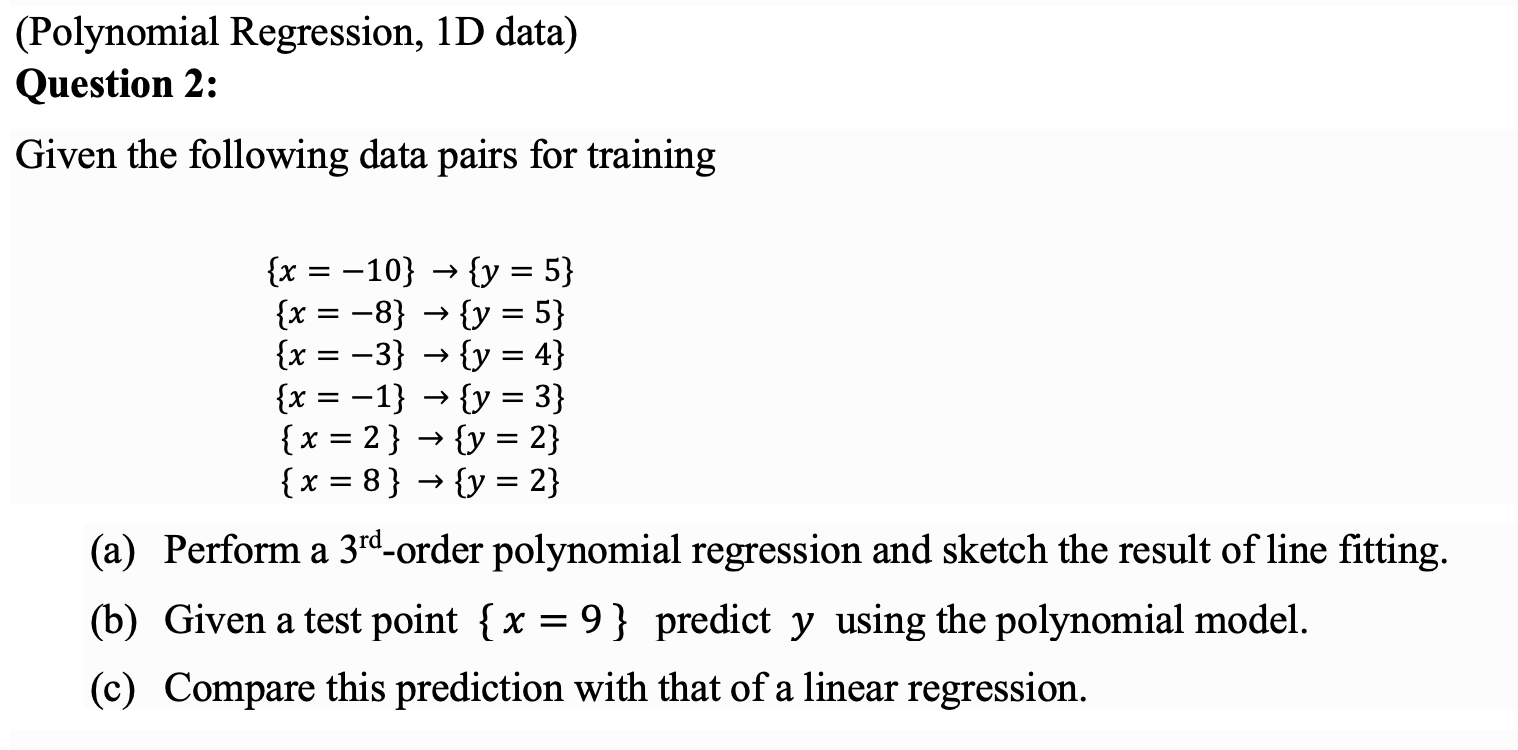

In [6]:
X = np.array([-10,-8,-3,-1,2,8]).reshape(6,1)
y = np.array([5,5,4,3,2,2]).reshape(6,1)
w_linear = apply_left_inverse(aug_X_first_coln(X),y,L = 0)


P = get_polynomial_data(X,order = 3) # get polynomial data
print('no. of monomials: ',how_many_monomials(d = X.shape[1],order = 3))
print('counting monomials method: ',use_which_form(X,3))
print('invertibility check: ',check_invertibility(P)) 
print('P:\n',P)

no. of monomials:  4
counting monomials method:  left
invertibility check:  (True, True)
P:
 [[    1.   -10.   100. -1000.]
 [    1.    -8.    64.  -512.]
 [    1.    -3.     9.   -27.]
 [    1.    -1.     1.    -1.]
 [    1.     2.     4.     8.]
 [    1.     8.    64.   512.]]


In [8]:
w_poly = apply_left_inverse(P,y,L = 0) # NO ridge term. 
print('w_poly: ', w_poly)
print('w_linear: ',w_linear)

w_poly:  [[ 2.68935636]
 [-0.37722517]
 [ 0.01343815]
 [ 0.00285772]]
w_linear:  [[ 3.10550459]
 [-0.19724771]]


In [9]:
from itertools import chain
coeff = list(chain.from_iterable(w_poly.tolist()))[::-1]
print(coeff)

[0.002857719286188419, 0.013438154796584235, -0.3772251716953795, 2.6893563584657105]


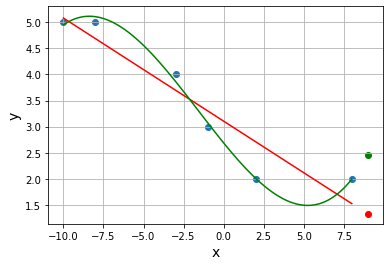

In [10]:
from matplotlib import pyplot as plt
from itertools import chain

X_aug = aug_X_first_coln(X) # append 1 infront
y_linear = X_aug @ w_linear #y = mx
coeff = list(chain.from_iterable(w_poly.tolist()))[::-1]

x_poly = np.linspace(-10,8,100)
y_poly = [np.polyval(coeff, i) for i in x_poly]

x_test = [9]
y_linear_pred = 9 * w_linear[1] + w_linear[0]
y_poly_pred = [np.polyval(coeff,9)]

plt.scatter(x_test, y_linear_pred, color = 'red')
plt.scatter(x_test,y_poly_pred, color = 'green')
plt.scatter(X, y, marker='o')
plt.plot(X, y_linear, color = 'red')
plt.plot(x_poly, y_poly, color = 'green')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.grid(True)
plt.show()

# Question 3
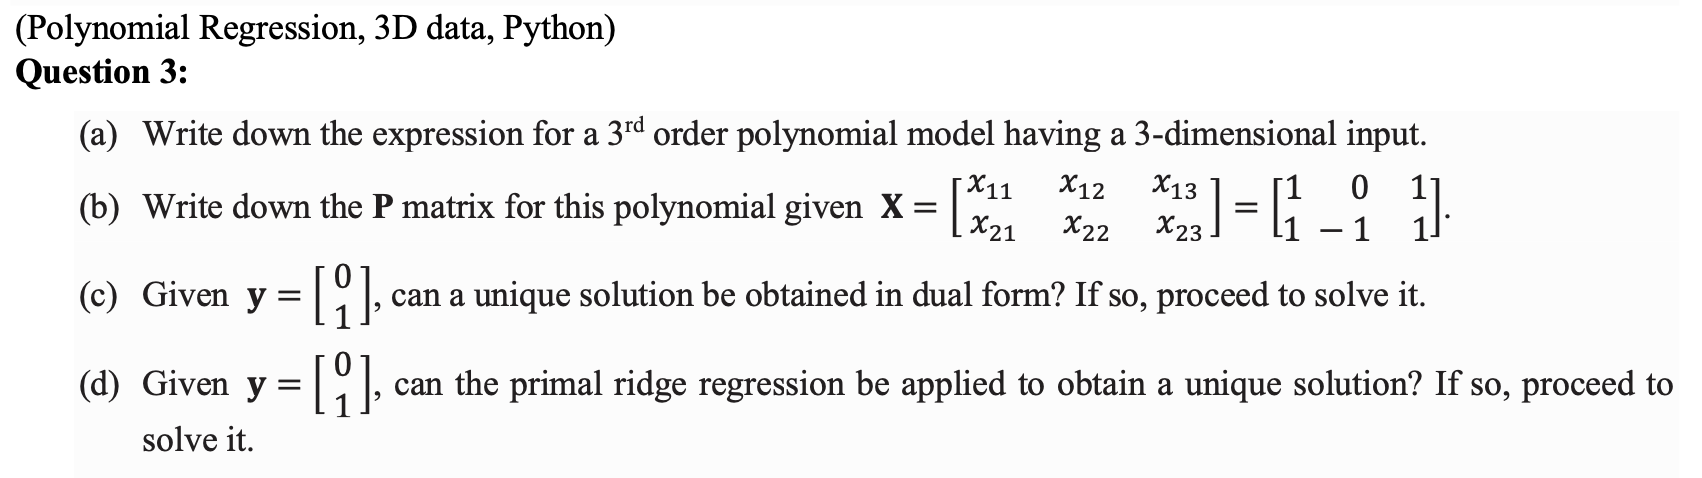

In [11]:
#### part(b)
X = np.array([1,0,1,1,-1,1]).reshape(2,3)
P = get_polynomial_data(X,order = 3)

print('X:\n',X)
print('P:\n',P)

X:
 [[ 1  0  1]
 [ 1 -1  1]]
P:
 [[ 1.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.
   0.  1.]
 [ 1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1.
  -1.  1.]]


In [12]:
##### part(c)
check_invertibility(P)

(False, True)

we can use dual form but not primal form. For primal form, we will need primal ridge regression.

In [13]:
#### part(c) continued
y = np.array([0,1]).reshape(2,1)
w_dual = apply_right_inverse(P,y,L= 0) #polynomial weights
print('w_dual: ',list(chain.from_iterable(w_dual.tolist())))

w_dual:  [0.0, 0.0, -0.1, 0.0, 0.0, -0.1, 0.0, 0.1, -0.1, 0.0, 0.0, -0.1, 0.0, 0.1, -0.1, 0.0, -0.1, 0.1, -0.1, 0.0]


In [14]:
### part (d)
w_primal_ridge = apply_left_inverse(P,y,L = 0.0001)
print('w_primal_ridge: ', list(chain.from_iterable(w_primal_ridge.tolist())))

w_primal_ridge:  [9.999698704632465e-07, 9.999710073316237e-07, -0.09999800005163464, 9.999738495025667e-07, 9.999722578868386e-07, -0.09999800005027129, 9.99970438897435e-07, 0.0999980000511362, -0.09999800005007341, 9.99970097836922e-07, 9.999698704632465e-07, -0.0999980000508692, 9.999687335948693e-07, 0.09999800005132395, -0.09999800004848178, 9.999702115237596e-07, -0.09999800005166501, 0.09999800004939127, -0.09999800004870915, 9.999657777370885e-07]


# Question 4
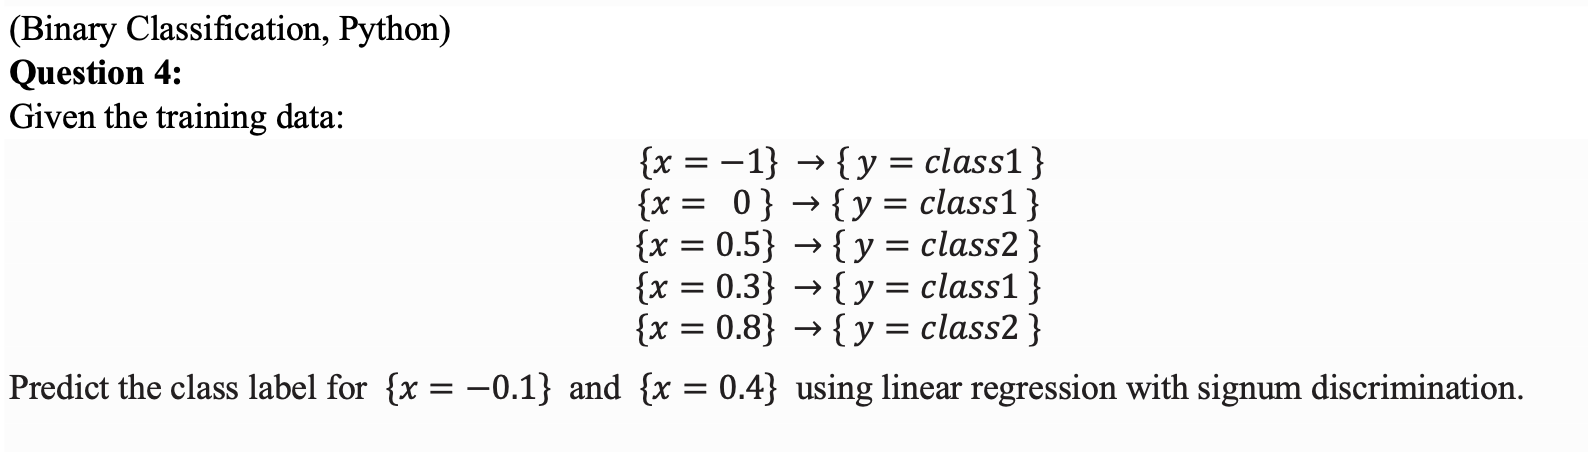

In [15]:
X = np.array([-1,0,0.5,0.3,0.8]).reshape(5,1)
y = np.array([1,1,-1,1,-1]).reshape(5,1) #encode classes as +-1
X_aug = aug_X_first_coln(X)
w_linear = apply_left_inverse(X_aug,y, L = 0)

X_test = np.array([-0.1,0.4]).reshape(2,1)
X_test_aug = aug_X_first_coln(X_test)
y_pred = X_test_aug @ w_linear
print("y_pred:\n",y_pred)

class_pred = [1 if i > 0 else 2 for i in y_pred] # can use numpy.sign
print("class_prediction:\n",class_pred )

y_pred:
 [[ 0.44444444]
 [-0.11111111]]
class_prediction:
 [1, 2]


# Question 5
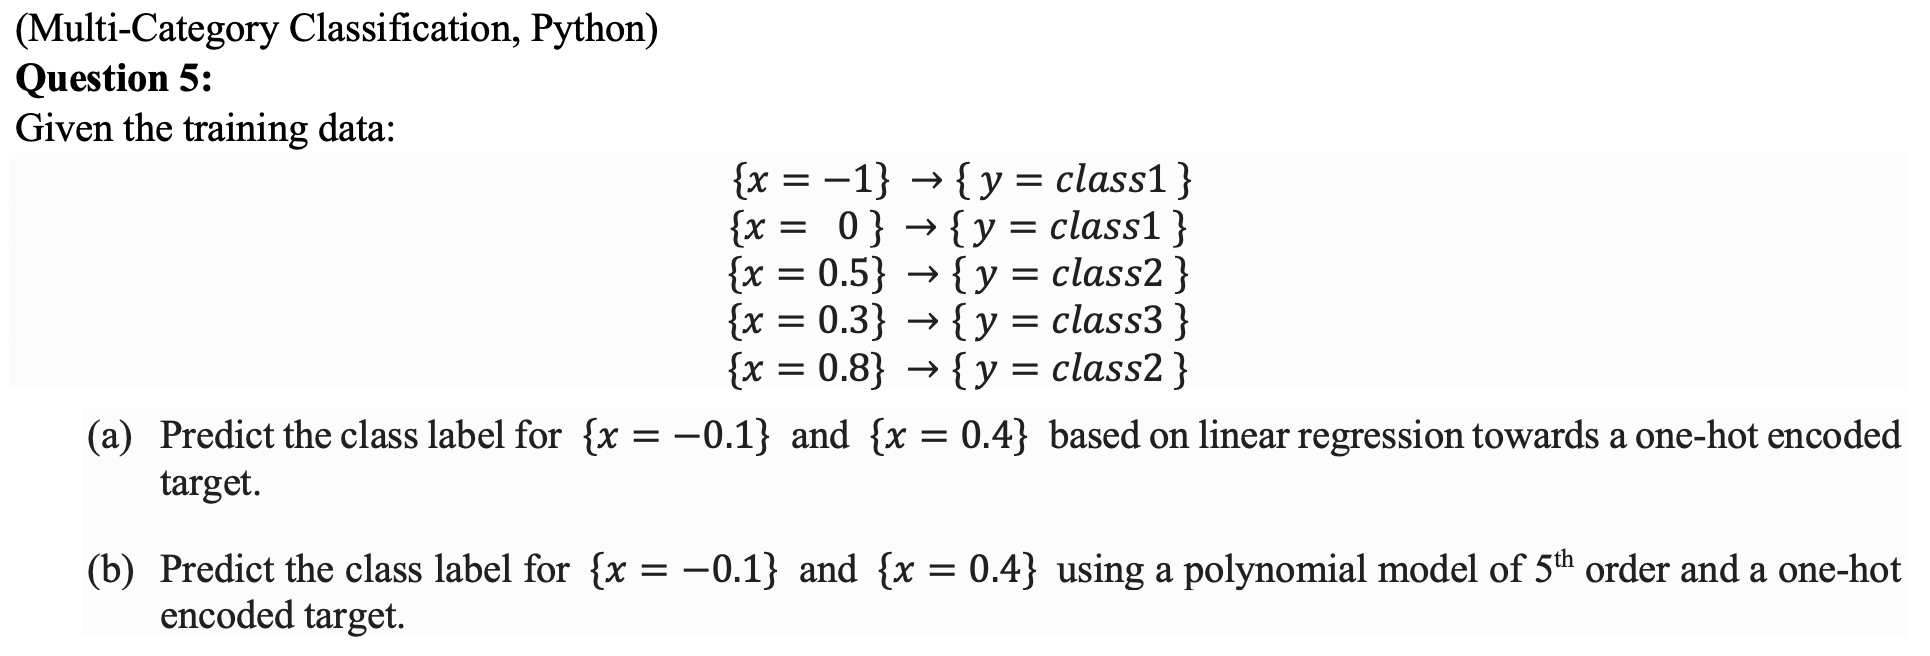

In [16]:
# notice the one-hot-encoding method
X = np.array([-1,0,0.5,0.3,0.8]).reshape(5,1)
Y = np.array([1,0,0,1,0,0,0,1,0,0,0,1,0,1,0]).reshape(5,3)
print("Y:\n",Y)
#linear regression: estimating w
X_aug = aug_X_first_coln(X)
w_linear = apply_left_inverse(X_aug,Y, L = 0)
print("w:\n",w_linear)
#linear regression: getting y_pred
X_test = np.array([-0.1,0.4]).reshape(2,1)
X_test_aug = aug_X_first_coln(X_test)

y_pred = X_test_aug @ w_linear
print("y_pred:\n",y_pred)

Y:
 [[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]]
w:
 [[ 0.47798742  0.33333333  0.18867925]
 [-0.64989518  0.55555556  0.09433962]]
y_pred:
 [[0.54297694 0.27777778 0.17924528]
 [0.21802935 0.55555556 0.22641509]]


**how to get the final prediction from the y_pred?** pick the highest!


In [17]:
def decoding_ohe(Y):
    m,d = Y.shape
    pred_class = -1 * np.ones(m)
    best = np.amax(Y,axis = 1)
    for i in range(m):
        for j in range(d):
            if best[i] == Y[i,j]:
                pred_class[i] = j
    
    return pred_class

In [18]:
pred_class = decoding_ohe(y_pred)
print('pred_class:\n',pred_class)

pred_class:
 [0. 1.]


In [19]:
#### polynomial model of order 5
P = get_polynomial_data(X,order = 5)
### need to use primal form BECAUSE
print("how_many_monomials: ", how_many_monomials(X.shape[1],5))
print("use_which_form: ",use_which_form(P,5))

how_many_monomials:  6
use_which_form:  right


In [20]:
w_poly = apply_right_inverse(P, Y, L = 0)
print("w:\n",w_poly)

X_test = np.array([-0.1,0.4]).reshape(2,1)
P_test = get_polynomial_data(X_test,order = 5)

y_pred = P_test @ w_poly
print("y_pred:\n",y_pred)



w:
 [[ 1.00000000e+00  1.77635684e-14 -5.68434189e-14]
 [-5.30313768e+00 -3.70234958e+00  9.00548727e+00]
 [ 5.21976232e+00  1.08728407e+01 -1.60926030e+01]
 [ 6.66624941e+00  9.46978846e+00 -1.61360379e+01]
 [-6.47651463e+00 -1.29098961e+01  1.93864107e+01]
 [-2.61986403e+00 -7.80449422e+00  1.04243583e+01]]
y_pred:
 [[ 1.57522369  0.46828063 -1.04350432]
 [-0.05207932  0.45436978  0.59770954]]


In [21]:
pred_class = decoding_ohe(y_pred)
print('pred_class:\n',pred_class)

pred_class:
 [0. 2.]
